In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.externals.six import StringIO  
from sklearn import tree
import math
from IPython.display import Image  
import pydotplus

In [2]:
# read in aggregated data
sj = pd.read_csv('../data/spatial_merged_solid.csv', encoding='latin-1')
sj = sj[['CAMIS', 'DBA', 'BBL', 'new_grade', 'yelp_rating', 'yelp_categories', 'yelp_review_count', 'stats.checkinsCount', 'stats.tipCount', 'stats.usersCount',
       'categories', 'geometry', 'BldgArea', 'BuiltFAR', 'CB2010', 'CT2010', 'HealthArea', 'NumFloors','OfficeArea',
        'ResArea', 'RetailArea', 'SHAPE_Area', 'SHAPE_Leng', 'TaxMap', 'Tract2010', 'UnitsRes', 'UnitsTotal', 'YearAlter1', 'YearAlter2', 'YearBuilt']]
sj = sj.rename(columns = {'yelp_rating':'yr', 'yelp_categories':'yc', 'yelp_review_count': 'yrc', \
                            'stats.checkinsCount':'fcc', 'stats.tipCount':'ftc', 'stats.usersCount':'fus', 'categories': 'fc'})
# consistent format
sj.BBL = sj.BBL.apply(int).apply(str)

In [3]:
### loading categories dicitonary
subs = dict()
with open ('../data/categories.csv', 'r') as f:
    for row in f:
        temp = row.split(',')
        if (temp[1].lower() not in subs.keys()) & (temp[2].strip().lower() not in subs.keys()): 
            subs[temp[1].strip().lower()] = temp[2].strip().lower()
            subs[temp[2].strip().lower()] = temp[2].strip().lower()
        if temp[2].strip().lower() in subs.keys():
            subs[temp[1].strip().lower()] = temp[2].strip().lower()

In [4]:
sj['yc'] = sj['yc'].str.replace(']',"").str.replace('[',
            "").str.replace("u'","").str.replace("'",
            "").str.replace(" ","").str.split(",")

In [5]:
sj['fc'] = sj['fc'].str.replace(" ","").str.split("/")

In [6]:
def get_list(row):
    output = []
    import itertools
    if type(row['yc']) != list:
        row['yc'] = ['NAN']
    if type(row['fc']) != list:
        row['fc'] = ['NAN']    
    map(subs.get, row['yc'], row['yc'])
    output.append(row['yc'])
    output.append(row['fc'])
    result = list(itertools.chain(*output))
    result = [x for x in result if x!='NAN']
    result = list(map(str.lower, result))
    result_2 = list(map(dict(zip(subs.keys(), subs.values())).get, result))
    final = list(set(result).union(set(result_2)))
    final = [x for x in final if x!= None]
    return final


### map to major_categories --> This method will miss lots of features
def major_categories(x):
    x = x.lower().replace('/', ' ')
    
    cat_list = x.split(' ')
    match = list(map(dict(zip(subs.keys(), subs.values())).get, cat_list))
    match = [x for x in match if x!= None]
    
    if len(match) ==0:
        retu
    else:
        final = match[0]
    return final

In [7]:
### original restaurant data 
origina_data = pd.read_csv('../data/clean_bz.csv')
frame = origina_data[['CAMIS', 'CUISINE DESCRIPTION']]

In [8]:
# yelp review and foursquare information
social_media = sj[['CAMIS', 'yc', 'fc']]
social_media['clean_tags'] = sj.apply(get_list, axis=1).apply(lambda x: ' '.join(x))

# topic modeling 
data_samples = social_media['clean_tags']

C:\Users\Public\anaconda3\envs\mlcv35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# merge data, clean missing value 
categories = pd.merge(frame, social_media[['CAMIS', 'clean_tags']], on= 'CAMIS', how='left')

categories = categories.dropna(subset=['clean_tags'])

In [10]:
bb = categories.groupby(['CUISINE DESCRIPTION'])['clean_tags'].apply(lambda x: ' '.join(x)).reset_index()

In [11]:
test123 = bb.set_index('CUISINE DESCRIPTION')['clean_tags']

### try tf-idf with nltk

In [50]:
import nltk


def preprocesssing(row):
    tokenizer = nltk.RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    tokens = tokenizer.tokenize(row['clean_tags'])
    text = nltk.Text(tokens, name=row['CUISINE DESCRIPTION'])
    return tokens, text

In [51]:
bb['nltk_token'], bb['nltk_text'] = zip(*bb.apply(preprocesssing, axis=1))

In [52]:
corpus = nltk.TextCollection(list(bb['nltk_text'].values))

In [58]:
def tf_idf(row):
    tf_idf = {}
    for word in row['nltk_token']:
        score = corpus.tf_idf(word, row['nltk_text'])
        tf_idf[word] = score
    return tf_idf,sorted(tf_idf.keys(), key=tf_idf.get)[:10]
def BoW(row):
    from collections import Counter
    boW = {}
    wordcounts = Counter(row['nltk_text'])
    for word in row['nltk_token']:
        if word not in boW.keys():
            score = wordcounts[word]
            boW[word] = score
    return boW,sorted(boW.keys(), key=boW.get)[:10]

In [61]:
bb['tf_idf'], bb['tf_idf_top_10'] = zip(*bb.apply(tf_idf, axis=1))

In [59]:
bb['bow'], bb['bow_top_10'] = zip(*bb.apply(BoW, axis=1))

In [17]:
bb.to_pickle('../data/categories_result.pkl')

In [34]:
bb['token'] = bb['clean_tags'].apply(lambda x:x.split(' '))

In [62]:
table = bb[['CUISINE DESCRIPTION', 'tf_idf_top_10']].set_index('CUISINE DESCRIPTION')

In [64]:
table2 = bb[['CUISINE DESCRIPTION', 'bow_top_10']].set_index('CUISINE DESCRIPTION')

In [67]:
table.tf_idf_top_10.apply(pd.Series).head(10)

,0,1,2,3,4,5,6,7,8,9
CUISINE DESCRIPTION,,,,,,,,,,
Afghan,seafood,italian,restaurant,pizza,foodtruck,indian,kebab,middleeastern,halal,afghani
African,american,mediterranean,middleeastern,cocktailbars,mexican,breakfast_brunch,food,spanish,caribbean,halal
American,african,noodles,peruvian,ramen,easterneuropean,foodtrucks,venezuelan,macarons,gelato,persian
Armenian,breakfast_brunch,mediterranean,bar,pizza,venues,southamerican,american,lounge,icecream,comfortfood
Asian,mediterranean,restaurant,bakeries,café,burgers,wine_bars,cafes,desserts,pubs,breakfast_brunch
Australian,american,newamerican,salad,bakeries,café,bar,vegan,gastropubs,coffee,breakfast_brunch
Bagels/Pretzels,american,desserts,italian,hotdogs,café,otherasia,burgers,pizza,cafes,trainstation
Bakery,salad,tradamerican,cocktailbars,otherasia,lounges,wine_bars,vegetarian,vegan,venues,japanese
Bangladeshi,american,newamerican,desserts,restaurant,chinese,food,bodega,deli,latinamerican,afghani


In [68]:
table2.bow_top_10.apply(pd.Series).head(10)

,0,1,2,3,4,5,6,7,8,9
CUISINE DESCRIPTION,,,,,,,,,,
Afghan,foodtruck,indian,pizza,seafood,italian,restaurant,kebab,afghan,halal,afghani
African,nightclub,foodtruck,food,airport,southafrican,halal,spanish,importedfood,caribbean,neighborhood
American,medical,zoo,conventioncenter,artschools,pharmacy,szechuan,gardens,churches,appliances,musicschool
Armenian,sports_clubs,hotel,romanian,venues,sportsbar,pizza,lounge,profit,office,non
Asian,tea,hotel,panasian,bakeries,brazilian,corporatecafeteria,food_court,karaoke,sakebar,tearoom
Australian,vegan,bar,gastropubs,bakeries,café,american,newamerican,salad,gluten_free,coffee
Bagels/Pretzels,pizza,burgers,trainstation,hotdogs,café,breakfast,donuts,korean,desserts,otherasia
Bakery,vegan,pharmacy,busstation,greek,brazilian,gelato,petservice,haitian,argentinian,creperies
Bangladeshi,bodega,food,malay,deli,restaurant,desserts,latinamerican,afghani,chinese,residencehall


### Categories tag visualization

In [110]:
a = bb['bow'][4]

In [112]:
text = " ".join(" ".join([k]*v) for (k,v) in a.items())

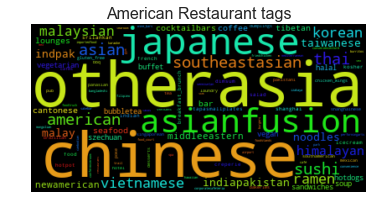

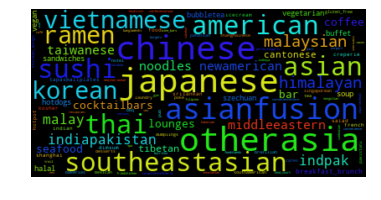

In [113]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.title('American Restaurant tags', fontsize=16)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

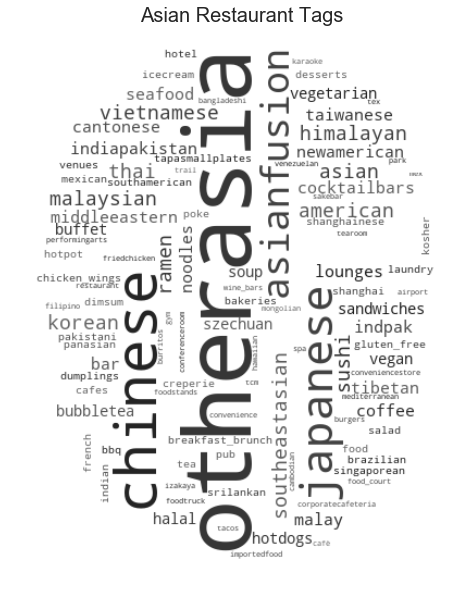

In [116]:
from os import path
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(10, 40)


# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
alice_mask = np.array(Image.open('../data/chinese.jpg'))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask,
               stopwords=stopwords)

plt.figure(figsize=(8,10))
# generate word cloud
wc.generate(text)
default_colors = wc.to_array()
plt.title("Asian Restaurant Tags", fontsize=20)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")

# store to file
wc.to_file(path.join('../data/food_img_2.png'))

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()

### sklearn pipeline for topic modeling 

In [22]:
## sklearn example
n_features = 300
n_topics = 10
n_top_words = 10


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(data_samples)

nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
Topic #0:
italian pizza wine_bars chicken_wings salad sandwiches seafood bars middleeastern kosher
Topic #1:
chinese asian szechuan noodles otherasia cantonese dimsum restaurants seafood asianfusion
Topic #2:
coffeeshop coffee cafes breakfast_brunch café juicebars bagels sandwiches bakeries bubbletea
Topic #3:
american burgers newamerican tradamerican fastfood chicken_wings breakfast_brunch hotdogs bars friedchicken
Topic #4:
sandwiches metro hotdogs salad breakfast_brunch delis fastfood deli bodega café
Topic #5:
bakery bakeries desserts cafes coffee caribbean breakfast_brunch café cupcakes southamerican
Topic #6:
japanese sushi otherasia asianfusion ramen asian seafood korean southeastasian thai
Topic #7:
mexican tacos hotdogs mex tex bars spanish mediterranean southamerican latin
Topic #8:
donuts coffee icecream café breakfast_brunch desserts bagels juicebars bubbletea diner
Topic #9:
bar bars pubs lounges sportsbars divebars cocktailbars tradam

In [ ]:
## returning topic from NMF

from sklearn import preprocessing
W = preprocessing.normalize(nmf.fit_transform(tfidf), norm='l2', copy=False)
H = preprocessing.normalize(nmf.components_, norm='l2', copy=False)

In [ ]:
social_media['topic'] = np.argmax(W, axis=1)

In [ ]:
output_csv = social_media[['CAMIS', 'topic']]

In [ ]:
output_csv = output_csv.join(pd.get_dummies(output_csv.topic).add_prefix('topic_'))

In [ ]:
output_csv.to_csv('../data/topic_output.csv', encoding='utf-8')